# LOKI: Large-scale Data Reconstruction Attack against Federated Learning through Model Manipulation 

In [1]:

import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
from statistics import NormalDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
import torchmetrics
from math import log10
import copy

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
import warnings
warnings.filterwarnings("ignore")

## Load in dataset

In [2]:
dataset_used = 'cifar'

if dataset_used == 'mnist':
    data_ch = 1
    im_dim  = [28,28]
    dst = datasets.MNIST("~/.torch", download=True)
    num_classes = 10
elif dataset_used == 'cifar':
    data_ch = 3
    im_dim  = [32,32]
    dst = datasets.CIFAR10("~/.torch", download=True)
    num_classes = 10
    
tp = transforms.Compose([
    transforms.Resize(im_dim[0]),
    transforms.CenterCrop(im_dim[0]),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def norm_image(image):
    x = copy.deepcopy(image)
    x = torch.abs(x)
    x = x - min(x)
    x = x/max(x)
    return x

def psnr(inp, target):
    return(10 * log10(1 / F.mse_loss(inp, target)))

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [02:28<00:00, 1146561.66it/s]


Extracting C:\Users\manis/.torch\cifar-10-python.tar.gz to C:\Users\manis/.torch


## Computing average pixel intensity distribution of images to set up FC layer biases

Mean: 0.4733630142373343 Std: 0.1252652199273531
Min: 0.030916817486286163 Max: 0.9893995126088461



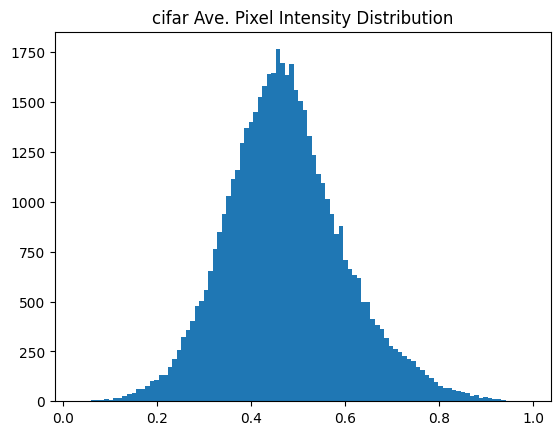

In [3]:
im_sums = []

for i in range(len(dst)):
    im_sums.append(torch.sum(tp(dst[i][0])).item()/(im_dim[0]*im_dim[1]*data_ch))
    
print("Mean:", np.mean(im_sums), "Std:", np.std(im_sums))
print("Min:", np.min(im_sums), "Max:", np.max(im_sums))
print()

plt.hist(im_sums, bins=100)
plt.title(dataset_used + ' Ave. Pixel Intensity Distribution')
plt.show()
print()

class imprintLayer(nn.Module):
    def __init__(self, number_bins, data_ch=3, im_dim=[32,32], conv_sizes=0):
        super(imprintLayer, self).__init__()
        self.conv1 = nn.Conv2d(data_ch, conv_sizes, (3,3), padding='same')
        self.act = torch.nn.Hardtanh(min_val=0, max_val=1)
        self.FC1 = nn.Linear(conv_sizes*im_dim[0]*im_dim[1], number_bins)
        self.FC2 = nn.Linear(number_bins, data_ch*im_dim[0]*im_dim[1])
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.act(self.FC1(x))
        x = F.relu(self.FC2(x))
        
        return x
    
def get_bins(num_bins, mu=0, sigma=1):
    bins = []
    mass = 0
    for path in range(num_bins + 1):
        mass += 1 / (num_bins + 2)
        bins += [NormalDist(mu=mu, sigma=sigma).inv_cdf(mass)]
        
    bins = torch.sort(torch.tensor(np.array(bins)))[0]
    
    bin_sizes = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
    bin_sizes = bin_sizes
    return bins[:-1], bin_sizes

## Number of clients, batch size, etc.

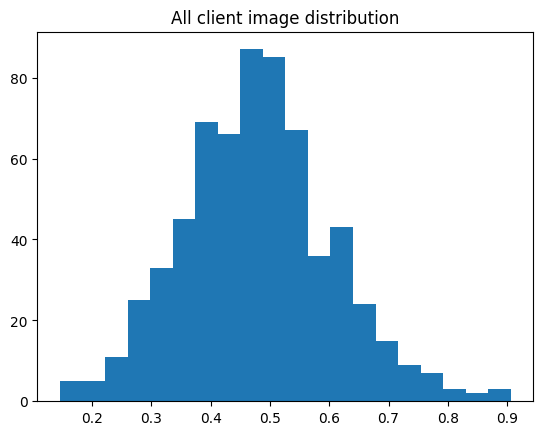

In [4]:
batch_size=64                      # Batch size
num_clients=10                      # Number of clients      
conv_sizes = num_clients*data_ch

perm = torch.randperm(len(dst))

img_index = perm[:(batch_size*num_clients)]
img_arr = []
label_arr = []
image_sum = []

for i in range(len(img_index)):
    gt_data = tp(dst[img_index[i]][0]).to(device)
    gt_label = torch.Tensor([dst[img_index[i]][1]]).long().to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=num_classes)

    img_arr.append(gt_data.detach().clone())
    label_arr.append(gt_label.detach().clone())
    image_sum.append(torch.sum(gt_data).item())

data_dist = []
for i in range(len(label_arr)):
    data_dist.append(image_sum[i]/(im_dim[0]*im_dim[1]*data_ch))

gt_data  = torch.cat(img_arr)
gt_onehot_label = torch.cat(label_arr)

plt.hist(data_dist, bins=20)
plt.title('All client image distribution')
plt.show()

## Run the attack

In [5]:
conv_scale  = 500      # this determines the value of the conv kernel. E.g., if conv_scale = 2, conv kernel value is 2 and weights = weights/2
    
bins_per_client = batch_size * 4    # Determines FC layer size
num_bins = bins_per_client

indice = 0   # indice of data to start at

num_epochs = 1
local_iters = 8
local_mini_batch_size = int(batch_size/local_iters)

print("Training with", local_iters, "local iterations")
print("Local mini-batch size:", local_mini_batch_size)
print()

metrics = True
learning_rate  = 1e-4


# ------------------------------------------------------------------------------------------------------------------------------------

mu = np.mean(im_sums)
sigma = np.std(im_sums)

criterion = nn.CrossEntropyLoss()

total_leaked = 0

recon_corresp_all = []
true_activations_summed_all = torch.zeros((num_clients,batch_size,num_bins))

psnr_arr_all = []
ssim_arr_all = []
lpip_arr_all = []

if metrics:
    from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')

for z in range(num_clients):
    
    net = imprintLayer(num_bins, data_ch, im_dim, conv_sizes)
    
    init_biases, bin_width = get_bins(num_bins, mu=mu, sigma=sigma)

    with torch.no_grad():
        net.FC1.weight = torch.nn.Parameter((1/conv_scale)*torch.ones(net.FC1.weight.size())/(im_dim[0]*im_dim[1]*data_ch)/torch.tensor(bin_width).unsqueeze(1))
        net.FC1.bias   = torch.nn.Parameter(-torch.tensor(init_biases)/torch.tensor(bin_width))    # net.FC1.bias[0].item() != init_biases[0], some minor precision loss

        single_client_conv1_weight = torch.zeros(net.conv1.weight.size())
        for j in range(data_ch):
            single_client_conv1_weight[j+z*data_ch, j, 1, 1] = 1 * conv_scale
        net.conv1.weight = torch.nn.Parameter(single_client_conv1_weight)

        net.conv1.bias = torch.nn.Parameter(torch.zeros(net.conv1.bias.size()))
        net.FC2.weight = torch.nn.Parameter(1000*torch.ones(net.FC2.weight.size()))
        net.FC2.bias   = torch.nn.Parameter(torch.zeros(net.FC2.bias.size()))

    Resnet = True
    if Resnet:

        my_mod = torchvision.models.resnet50()
        if data_ch != 3:
            my_mod.conv1 = nn.Conv2d(data_ch, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        class Resize(torch.nn.Module):
            def forward(self, x):
                batch_size = x.shape[0]
                return x.view(batch_size, data_ch, im_dim[0], im_dim[1])

        my_original_model = nn.Sequential(
            net.float(),
            Resize(),
            my_mod.float()

        )
    else:
        my_original_model = nn.Sequential(net)

    my_model = copy.deepcopy(my_original_model)
    optimizer = optim.SGD(my_model.parameters(), lr=learning_rate)

    client_indice = z

    original_net = []
    true_activations = torch.zeros((batch_size,num_bins))

    myvalue = data_ch*im_dim[0]*im_dim[1]
    
    for t in range(num_epochs):

        for i in range(local_iters):

            original_net.append(copy.deepcopy(my_model[0]))
            optimizer.zero_grad()

            with torch.no_grad():
                for q in range(int(local_mini_batch_size)):
                    for j in range(num_bins):
                        value = (torch.dot(F.relu(F.conv2d(gt_data[indice+i*int(local_mini_batch_size)+q + int(client_indice*batch_size)].unsqueeze(0)
                                                           ,my_model[0].conv1.weight,my_model[0].conv1.bias,padding='same'))[0,data_ch*z:data_ch*(z+1)].flatten(),
                                           my_model[0].FC1.weight[j][myvalue*z:myvalue*(z+1)]) + my_model[0].FC1.bias[j])   # myvalue*z:myvalue*(z+1)
                        if value > 0 and value < 1:
                            true_activations[q+i*int(local_mini_batch_size),j] += 1

            out = my_model(gt_data[indice+i*int(local_mini_batch_size) + int(client_indice*batch_size) 
                                   : indice+(i+1)*int(local_mini_batch_size) + int(client_indice*batch_size)])
            y = criterion(out, gt_onehot_label[indice+i*int(local_mini_batch_size) + int(client_indice*batch_size) 
                                               : indice+(i+1)*int(local_mini_batch_size) + int(client_indice*batch_size)])

            y.backward()

            optimizer.step()

    true_activations_summed = torch.sum(true_activations, axis=0)
    print("Client", client_indice, "activations:", torch.sum(true_activations_summed==1))
    total_leaked += torch.sum(true_activations_summed==1)

    num_client_scaling = True

    with torch.no_grad():
        if num_client_scaling:
            grad_w = (((original_net[0].FC1.weight * (num_clients-1)) + my_model[0].FC1.weight)/num_clients - original_net[0].FC1.weight)[:,myvalue*z:myvalue*(z+1)]
            grad_b = (((original_net[0].FC1.bias * (num_clients-1)) + my_model[0].FC1.bias)/num_clients - original_net[0].FC1.bias)
        else:
            grad_w = (net.FC1.weight - original_net[0].FC1.weight)[:,myvalue*z:myvalue*(z+1)]
            grad_b = (net.FC1.bias - original_net[0].FC1.bias)

    count = 0

    recon_corresp = []

    for r in range(batch_size):
        recon_corresp.append(torch.full((3, im_dim[0],im_dim[1]), float('nan')))

    psnr_arr = []
    ssim_arr = []
    lpip_arr = []

    for m in range(grad_w.size()[0]):
        if grad_w[m].abs().sum() != 0:
            count += 1
        if grad_w[m].abs().sum() != 0 and (grad_w[m]-grad_w[m][0]).abs().sum() != 0:
            if true_activations_summed[m] == 1:
                if metrics: 
                    if not np.isnan(norm_image(grad_w[m])[0]):

                        psnr_val = psnr(norm_image(grad_w[m]).reshape(data_ch,im_dim[0],im_dim[1]), gt_data[torch.nonzero(true_activations[:,m])[0][0] + int(client_indice*batch_size)])
                        psnr_arr.append(psnr_val)
                        psnr_arr_all.append(psnr_val)

                        ssim_val = torchmetrics.functional.structural_similarity_index_measure(norm_image(grad_w[m]).reshape(data_ch,im_dim[0],im_dim[1]).unsqueeze(0), 
                                                                                          gt_data[torch.nonzero(true_activations[:,m])[0][0] + int(client_indice*batch_size)].unsqueeze(0)).item()

                        ssim_arr.append(ssim_val)
                        ssim_arr_all.append(ssim_val)

                        lpip_val = lpips(norm_image(grad_w[m]).reshape(data_ch,im_dim[0],im_dim[1]).unsqueeze(0), 
                                         gt_data[torch.nonzero(true_activations[:,m])[0][0] + int(client_indice*batch_size)].unsqueeze(0)).item()
                        lpip_arr.append(lpip_val)
                        lpip_arr_all.append(lpip_val)

                recon_corresp[torch.nonzero(true_activations[:,m])[0][0]] = norm_image(grad_w[m]).reshape(data_ch,im_dim[0],im_dim[1])


    recon_corresp_all.append(recon_corresp)

print()
print("Number of clients:     ", num_clients)
print("Total number of images:", num_clients*batch_size)
print("Total images leaked:   ", total_leaked)
print("Leakage rate:"          , total_leaked/(num_clients*batch_size))
if metrics:
    print()
    print("Average PSNR leaked im: ", np.mean(psnr_arr_all))
    print("Average SSIM leaked im: ", np.mean(ssim_arr_all))
    print("Average LPIPS leaked im:", np.mean(lpip_arr_all))

Training with 8 local iterations
Local mini-batch size: 8



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\manis/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [00:52<00:00, 10.5MB/s]


Client 0 activations: tensor(55)
Client 1 activations: tensor(61)
Client 2 activations: tensor(52)
Client 3 activations: tensor(55)
Client 4 activations: tensor(59)
Client 5 activations: tensor(55)
Client 6 activations: tensor(57)
Client 7 activations: tensor(55)
Client 8 activations: tensor(54)
Client 9 activations: tensor(57)

Number of clients:      10
Total number of images: 640
Total images leaked:    tensor(560)
Leakage rate: tensor(0.8750)

Average PSNR leaked im:  41.051867879554834
Average SSIM leaked im:  0.9761493888284479
Average LPIPS leaked im: 0.008023904366206112


## Plot the images of a client

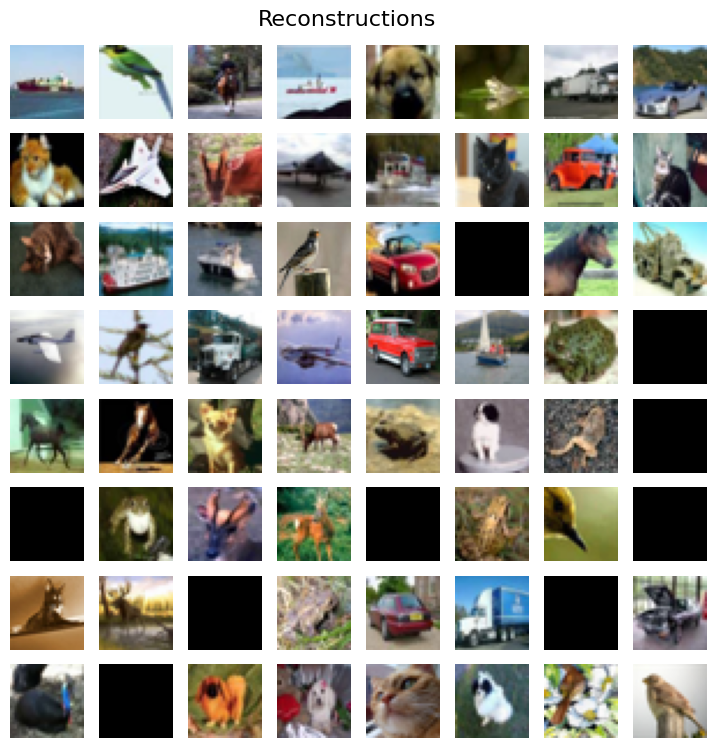

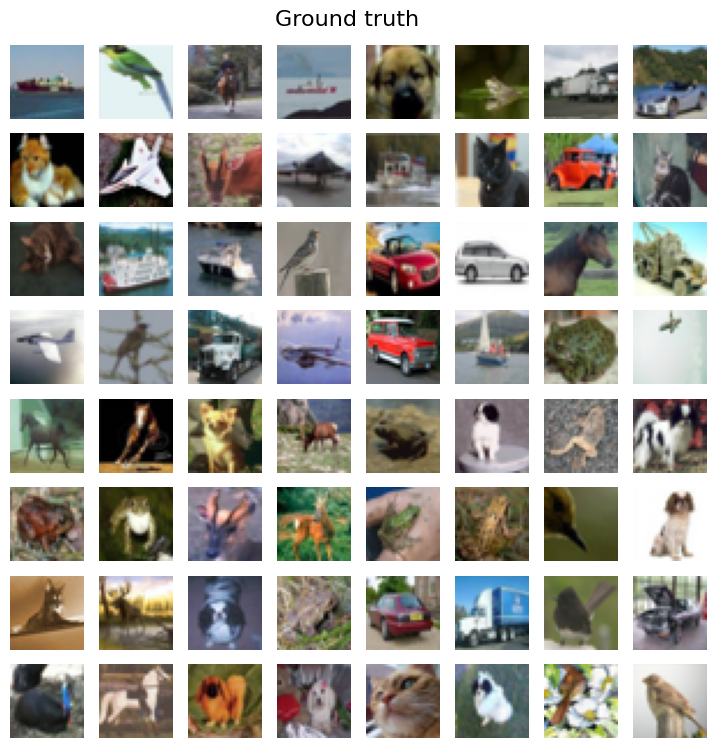

In [6]:
client_index = 0

fig, axs = plt.subplots(8, 8)
axs = axs.ravel()
for i in range(batch_size):
    axs[i].imshow(tt(recon_corresp_all[client_index][i]))
    axs[i].axis('off')
fig.set_figheight(9)
fig.set_figwidth(9)
fig.suptitle('Reconstructions', fontsize=16, y=0.92)
plt.show()
print()
print()
print()

fig, axs = plt.subplots(int(batch_size/8), 8)
axs = axs.ravel()
for i in range(batch_size):
    axs[i].imshow(tt(gt_data[i+client_index*batch_size].cpu()))
    axs[i].axis('off')

fig.set_figheight(9)
fig.set_figwidth(9)
fig.suptitle('Ground truth', fontsize=16, y=0.92)
plt.show()
